In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import jax
Array = jax.Array
import jax.numpy as jnp
import jax.scipy as jsp
from jax.scipy import optimize
import scipy.stats
import dataclasses
from functools import partial
from typing import Callable, Union

import optax

from VP_solver.jax_vp_solver import Mesh, make_mesh, VlasovPoissonSolver
from Utils.utils import plot_feq_distribution, plot_distribution

matplotlib.rcParams.update({
    'font.size': 14,  # General font size
    'axes.labelsize': 14,  # Axis label size
    'axes.titlesize': 14,  # Title size
    'xtick.labelsize': 14,  # X-tick label size
    'ytick.labelsize': 14,  # Y-tick label size
    'legend.fontsize': 14   # Legend font size
})

jax.config.update("jax_enable_x64", True)

print(jax.devices())

[CudaDevice(id=0)]


In [5]:
# Function to compute the external field H (not time-dependent)
def compute_external_field(ak, mesh):
    k = jnp.arange(1, len(ak[0,:]) + 1)  # Create an array of k values from 1 to len(a_k)
    H = ak[0,:] @ jnp.cos(k[:, None] * k_0 * mesh.xs) \
            + ak[1,:] @ jnp.sin(k[:, None] * k_0 * mesh.xs)  # Vectorized computation
    return H

def compute_external_field_sin(ak, mesh):
    k = jnp.arange(1, len(ak[:]) + 1)  # Create an array of k values from 1 to len(a_k)
    H = ak[:] @ jnp.sin(k[:, None] * k_0 * mesh.xs)  # Vectorized computation
    return H

In [6]:
# under-parametrized
k_total_1 = 2
# over-parametrized
k_total_2 = 14

### Two Stream

In [7]:
# Setup
nx = 256
nv = 256
dt = 0.1
t_final = 30  # Adjusted for demonstration purposes
t_values = jnp.linspace(0, t_final, int(t_final / dt))
L = 10 * jnp.pi
LV = 6.0

In [8]:
mesh = make_mesh(L, LV, nx, nv)

mu1 = 2.4
f_eq = (jnp.exp(-0.5*(mesh.V - mu1)**2) + jnp.exp(-0.5*(mesh.V + mu1)**2))/(2*jnp.sqrt(2*jnp.pi))
epsilon1 = 0.001 # Value to change
epsilon2 = 0.0 # Value to change
k_0 = 0.2
f_iv = (1 + epsilon1 * jnp.cos(k_0 * mesh.X) + epsilon2 * jnp.sin(k_0 * mesh.X)) * f_eq

In [9]:
solver = VlasovPoissonSolver(mesh=mesh, dt=dt, f_eq=f_eq)

# JIT-compiled forward solver
solver_jit = jax.jit(solver.run_forward_jax_scan, static_argnames=('t_final',))

In [10]:
#f_array1, E_array1, ee_array1 = solver_jit(f_iv, jnp.zeros_like(f_eq[0,:]), t_final=t_final)

In [11]:
#fig, axs = plt.subplots(1,4 ,figsize=(40, 7))


#plot_feq_distribution(fig, axs[0], f_eq, 'Distribution of $f_{eq}$', mesh)

#plot_distribution(fig, axs[1], f_array1, 'Distribution of $f$', t_final, mesh)

#axs[2].plot(mesh.xs, E_array1[0], label=f't={0*dt:.1f}')
#axs[2].plot(mesh.xs, E_array1[99], label=f't={100*dt:.1f}')
#axs[2].plot(mesh.xs, E_array1[199], label=f't={200*dt:.1f}')
#axs[2].plot(mesh.xs, E_array1[299], label=f't={300*dt:.1f}')
#axs[2].set_xlabel('$x$')
#axs[2].set_ylabel('$E(t,x)$')
#axs[2].set_title('$E(t,x)$ at different times')
#axs[2].legend()

#axs[3].ticklabel_format(axis='y', style='sci', scilimits=(-2,2))
#axs[3].plot(t_values, ee_array1)
#axs[3].set_xlabel('Time')
#axs[3].set_title('Electric Energy vs Time')


#plt.savefig('Plots/TS_noH.png', dpi=300, transparent=True, bbox_inches="tight")
#plt.show()


Below change between
- `k_total_1` (under) and `k_total_2` (over) for results with different parametrizations of $H$,
- `ee` (electric energy) and `KL`,
- `GD` (constant step) and `GDL` (linesearch).

Try all combinations (total should be $24$).

In [24]:
aks_far = jnp.load('Results_coeff/Two_Stream/new/GD/GDL_KL_eps1={}_eps2={}_k={}_coeffs_far.npy'.format(epsilon1,epsilon2, k_total_1))
objectives_far = jnp.load('Results_coeff/Two_Stream/new/GD/GDL_KL_eps1={}_eps2={}_k={}_objective_far.npy'.format(epsilon1,epsilon2, k_total_1))

In [25]:
aks_near = jnp.load('Results_coeff/Two_Stream/new/GD/GDL_KL_eps1={}_eps2={}_k={}_coeffs_near.npy'.format(epsilon1,epsilon2, k_total_1))
objectives_near = jnp.load('Results_coeff/Two_Stream/new/GD/GDL_KL_eps1={}_eps2={}_k={}_objective_near.npy'.format(epsilon1,epsilon2, k_total_1))

In [26]:
aks_local = jnp.load('Results_coeff/Two_Stream/new/GD/GDL_KL_eps1={}_eps2={}_k={}_coeffs_local.npy'.format(epsilon1,epsilon2, k_total_1))
objectives_local = jnp.load('Results_coeff/Two_Stream/new/GD/GDL_KL_eps1={}_eps2={}_k={}_objective_local.npy'.format(epsilon1,epsilon2, k_total_1))

Below change between `compute_external_field_sin` (when `k_total_1`) and `compute_external_field` (when `k_total_2`)

On the plotting cells, add the plotting of the landscape + trajectories at `axs[1,2]`.

In [27]:
H_far = compute_external_field_sin(aks_far[-1], mesh)
H_near = compute_external_field_sin(aks_near[-1], mesh)
H_local = compute_external_field_sin(aks_local[-1], mesh)

f_array1, E_array1, ee_array1 = solver_jit(f_iv, H_far, t_final=t_final)
f_array2, E_array2, ee_array2 = solver_jit(f_iv, H_near, t_final=t_final)
f_array3, E_array3, ee_array3 = solver_jit(f_iv, H_local, t_final=t_final)

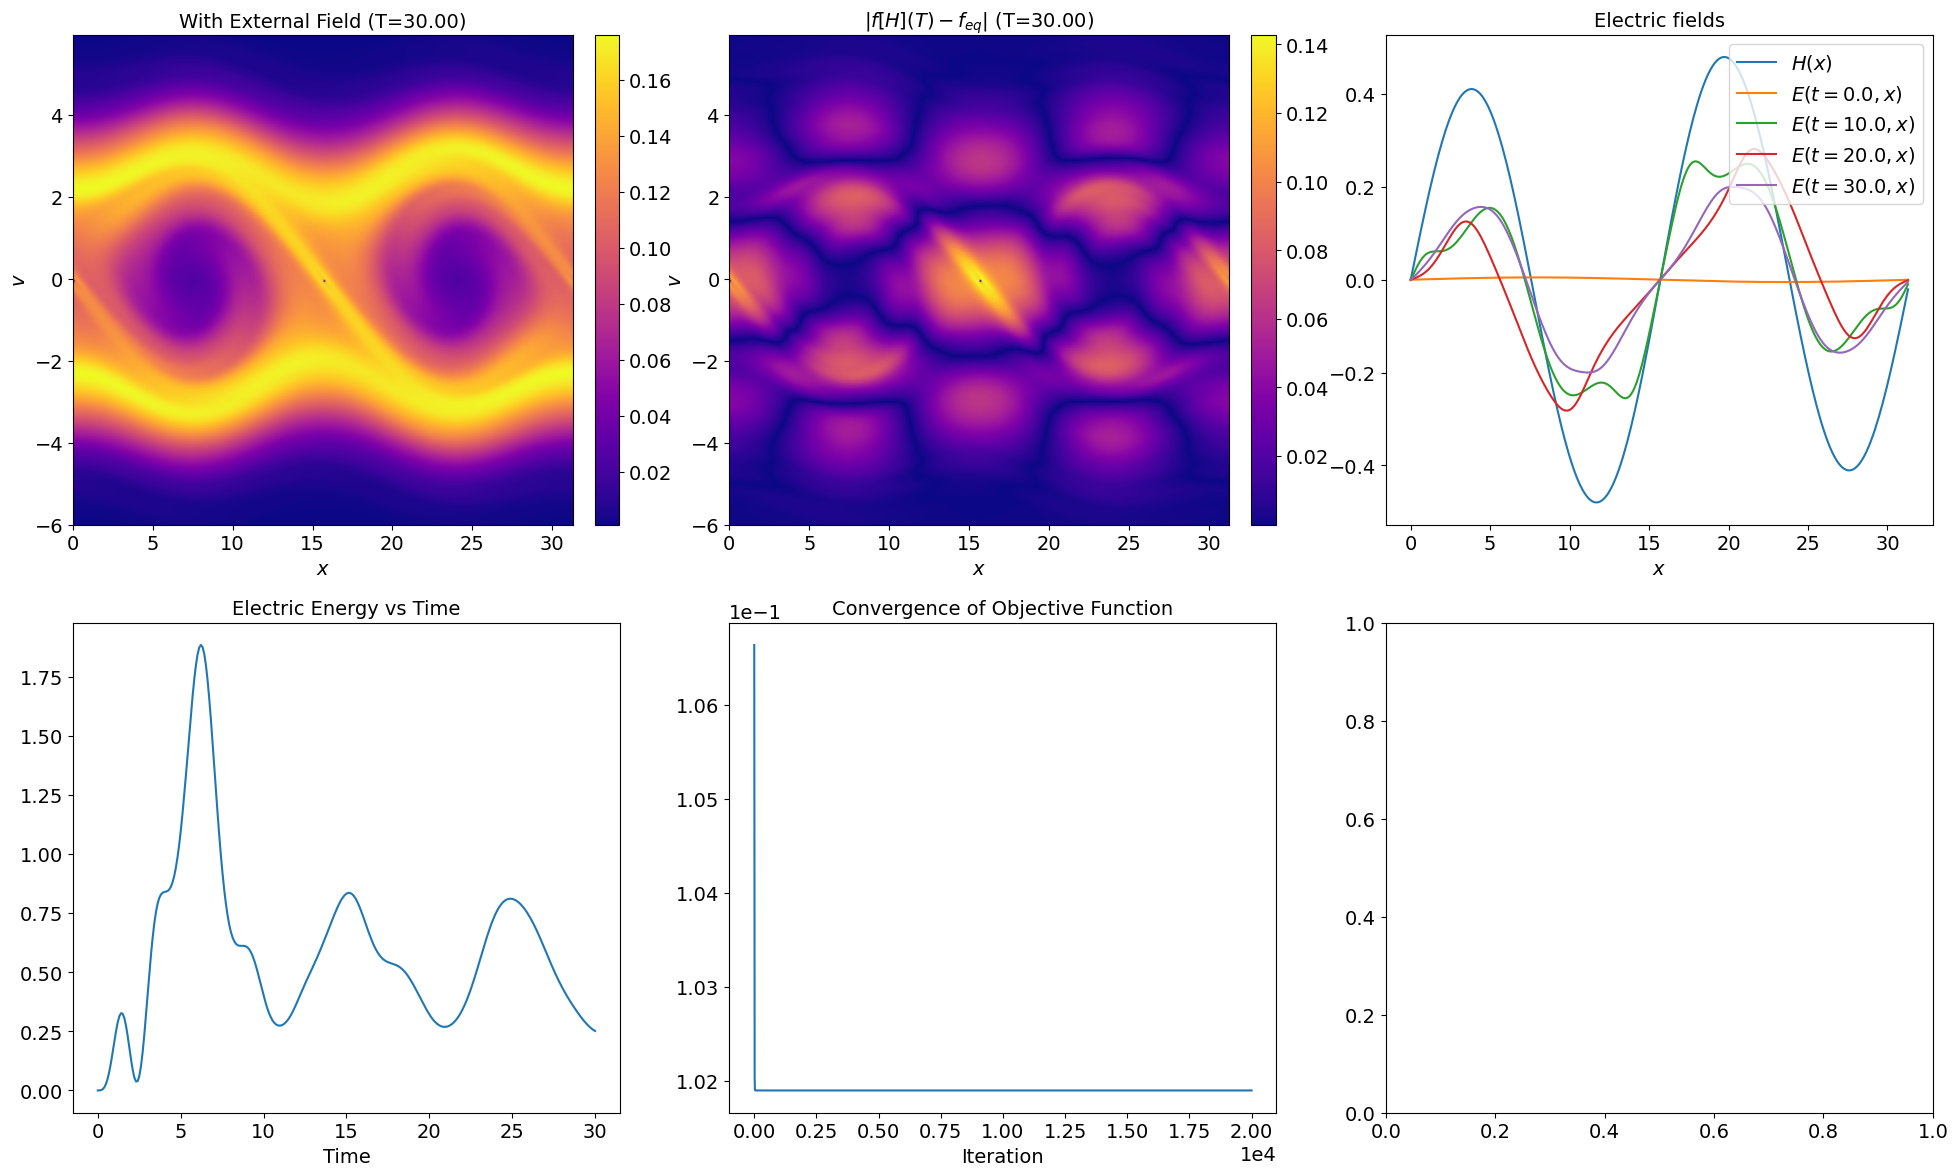

In [28]:
fig, axs = plt.subplots(2,3 ,figsize=(24, 14))


plot_distribution(fig, axs[0,0], f_array1, 'With External Field', t_final, mesh)

plot_distribution(fig, axs[0,1], jnp.abs(f_array1 - f_eq), '$|f[H](T) - f_{eq}|$', t_final, mesh)


axs[0,2].plot(mesh.xs, H_far, label='$H(x)$')
#axs[0,2].plot(mesh.xs, E_array1[-1] - H_far, label='$E(T,x)$')
axs[0,2].plot(mesh.xs, E_array1[0] - H_far, label=f'$E(t={0*dt:.1f},x)$')
axs[0,2].plot(mesh.xs, E_array1[99] - H_far, label=f'$E(t={100*dt:.1f},x)$')
axs[0,2].plot(mesh.xs, E_array1[199] - H_far, label=f'$E(t={200*dt:.1f},x)$')
axs[0,2].plot(mesh.xs, E_array1[299] - H_far, label=f'$E(t={300*dt:.1f},x)$')
axs[0,2].set_xlabel('$x$')
#axs[0,2].set_ylabel('Electric field')
axs[0,2].set_title('Electric fields')
axs[0,2].legend(loc='upper right')



#axs[1,0].plot(mesh.xs, E_array1[0] - H_far, label=f't={0*dt:.1f}')
#axs[1,0].plot(mesh.xs, E_array1[99] - H_far, label=f't={100*dt:.1f}')
#axs[1,0].plot(mesh.xs, E_array1[199] - H_far, label=f't={200*dt:.1f}')
#axs[1,0].plot(mesh.xs, E_array1[299] - H_far, label=f't={300*dt:.1f}')
#axs[1,0].set_xlabel('$x$')
#axs[1,0].set_ylabel('$E(t,x)$')
#axs[1,0].set_title('$E(t,x)$ at different times')
#axs[1,0].legend()


axs[1,0].ticklabel_format(axis='y', style='sci', scilimits=(-2,2))
axs[1,0].plot(t_values, ee_array1)
axs[1,0].set_xlabel('Time')
#axs[1,0].set_ylabel('Electric Energy')
axs[1,0].set_title('Electric Energy vs Time')


axs[1,1].ticklabel_format(axis='both', style='sci', scilimits=(0,0))#, useMathText=True)
axs[1,1].plot(objectives_far)
#axs[1,1].set_yscale('log')
axs[1,1].set_xlabel("Iteration")
#axs[1,1].set_ylabel("Objective value")
axs[1,1].set_title("Convergence of Objective Function")

# Add last subplot here


#plt.savefig('Plots/Two_Stream/GD_ee_eps1={}_eps2={}_k={}_coeffs_far.png'.format(epsilon1,epsilon2, k_total_1),
#            dpi=300, transparent=True, bbox_inches="tight")
plt.show()

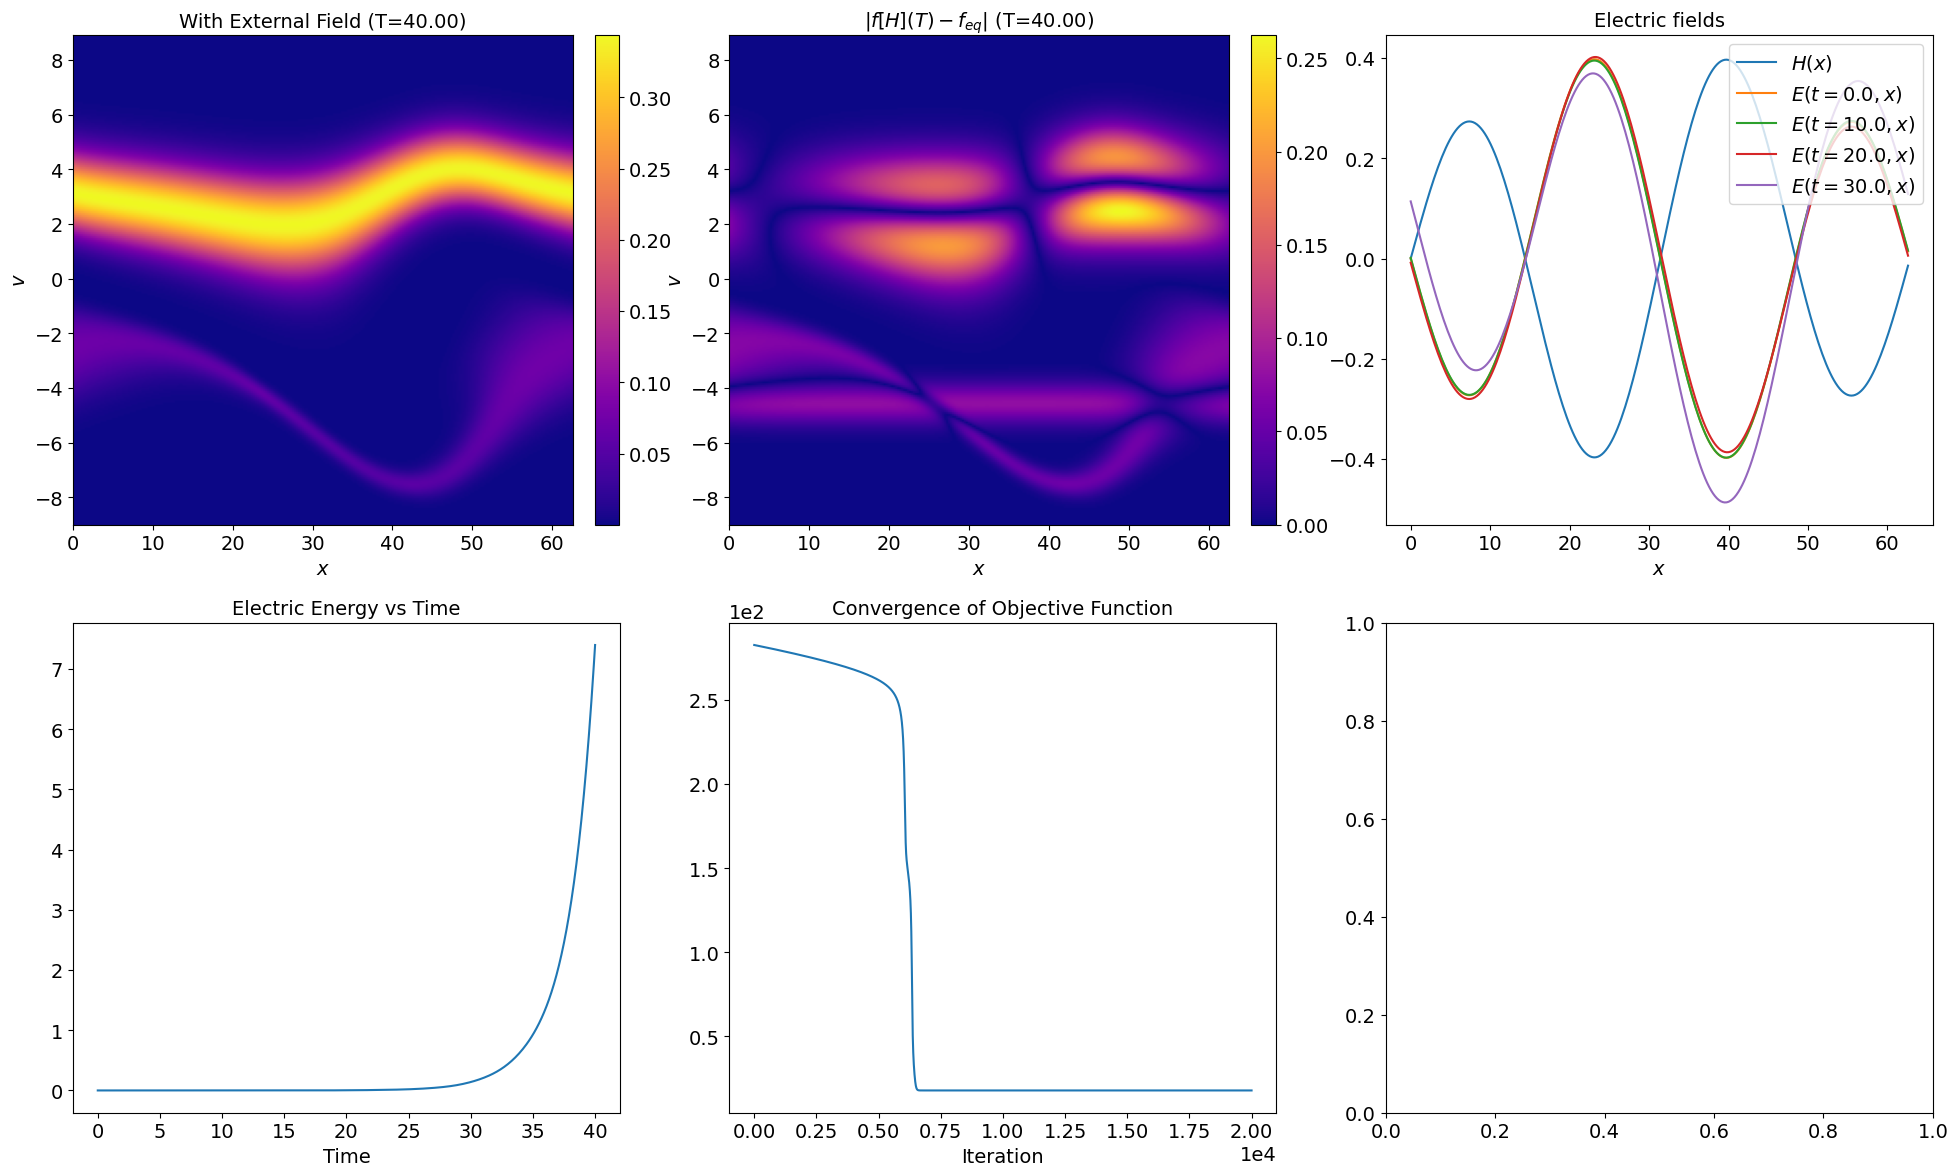

In [44]:
fig, axs = plt.subplots(2,3 ,figsize=(24, 14))


plot_distribution(fig, axs[0,0], f_array2, 'With External Field', t_final, mesh)

plot_distribution(fig, axs[0,1], jnp.abs(f_array2 - f_eq), '$|f[H](T) - f_{eq}|$', t_final, mesh)


axs[0,2].plot(mesh.xs, H_far, label='$H(x)$')
#axs[0,2].plot(mesh.xs, E_array2[-1] - H_near, label='$E(T,x)$')
axs[0,2].plot(mesh.xs, E_array2[0] - H_far, label=f'$E(t={0*dt:.1f},x)$')
axs[0,2].plot(mesh.xs, E_array2[99] - H_far, label=f'$E(t={100*dt:.1f},x)$')
axs[0,2].plot(mesh.xs, E_array2[199] - H_far, label=f'$E(t={200*dt:.1f},x)$')
axs[0,2].plot(mesh.xs, E_array2[299] - H_far, label=f'$E(t={300*dt:.1f},x)$')
axs[0,2].set_xlabel('$x$')
#axs[0,2].set_ylabel('Electric field')
axs[0,2].set_title('Electric fields')
axs[0,2].legend(loc='upper right')



#axs[1,0].plot(mesh.xs, E_array2[0] - H_near, label=f't={0*dt:.1f}')
#axs[1,0].plot(mesh.xs, E_array2[99] - H_near, label=f't={100*dt:.1f}')
#axs[1,0].plot(mesh.xs, E_array2[199] - H_near, label=f't={200*dt:.1f}')
#axs[1,0].plot(mesh.xs, E_array2[299] - H_near, label=f't={300*dt:.1f}')
#axs[1,0].set_xlabel('$x$')
#axs[1,0].set_ylabel('$E(t,x)$')
#axs[1,0].set_title('$E(t,x)$ at different times')
#axs[1,0].legend()


axs[1,0].ticklabel_format(axis='y', style='sci', scilimits=(-2,2))
axs[1,0].plot(t_values, ee_array2)
axs[1,0].set_xlabel('Time')
#axs[1,0].set_ylabel('Electric Energy')
axs[1,0].set_title('Electric Energy vs Time')


axs[1,1].ticklabel_format(axis='both', style='sci', scilimits=(0,0))
axs[1,1].plot(objectives_near)
#axs[1,1].set_yscale('log')
axs[1,1].set_xlabel("Iteration")
#axs[1,1].set_ylabel("Objective value")
axs[1,1].set_title("Convergence of Objective Function")


## Add subplot here

#plt.savefig('Plots/Two_Stream/GD_ee_eps1={}_eps2={}_k={}_coeffs_near.png'.format(epsilon1,epsilon2, k_total_1),
#            dpi=300, transparent=True, bbox_inches="tight")
plt.show()

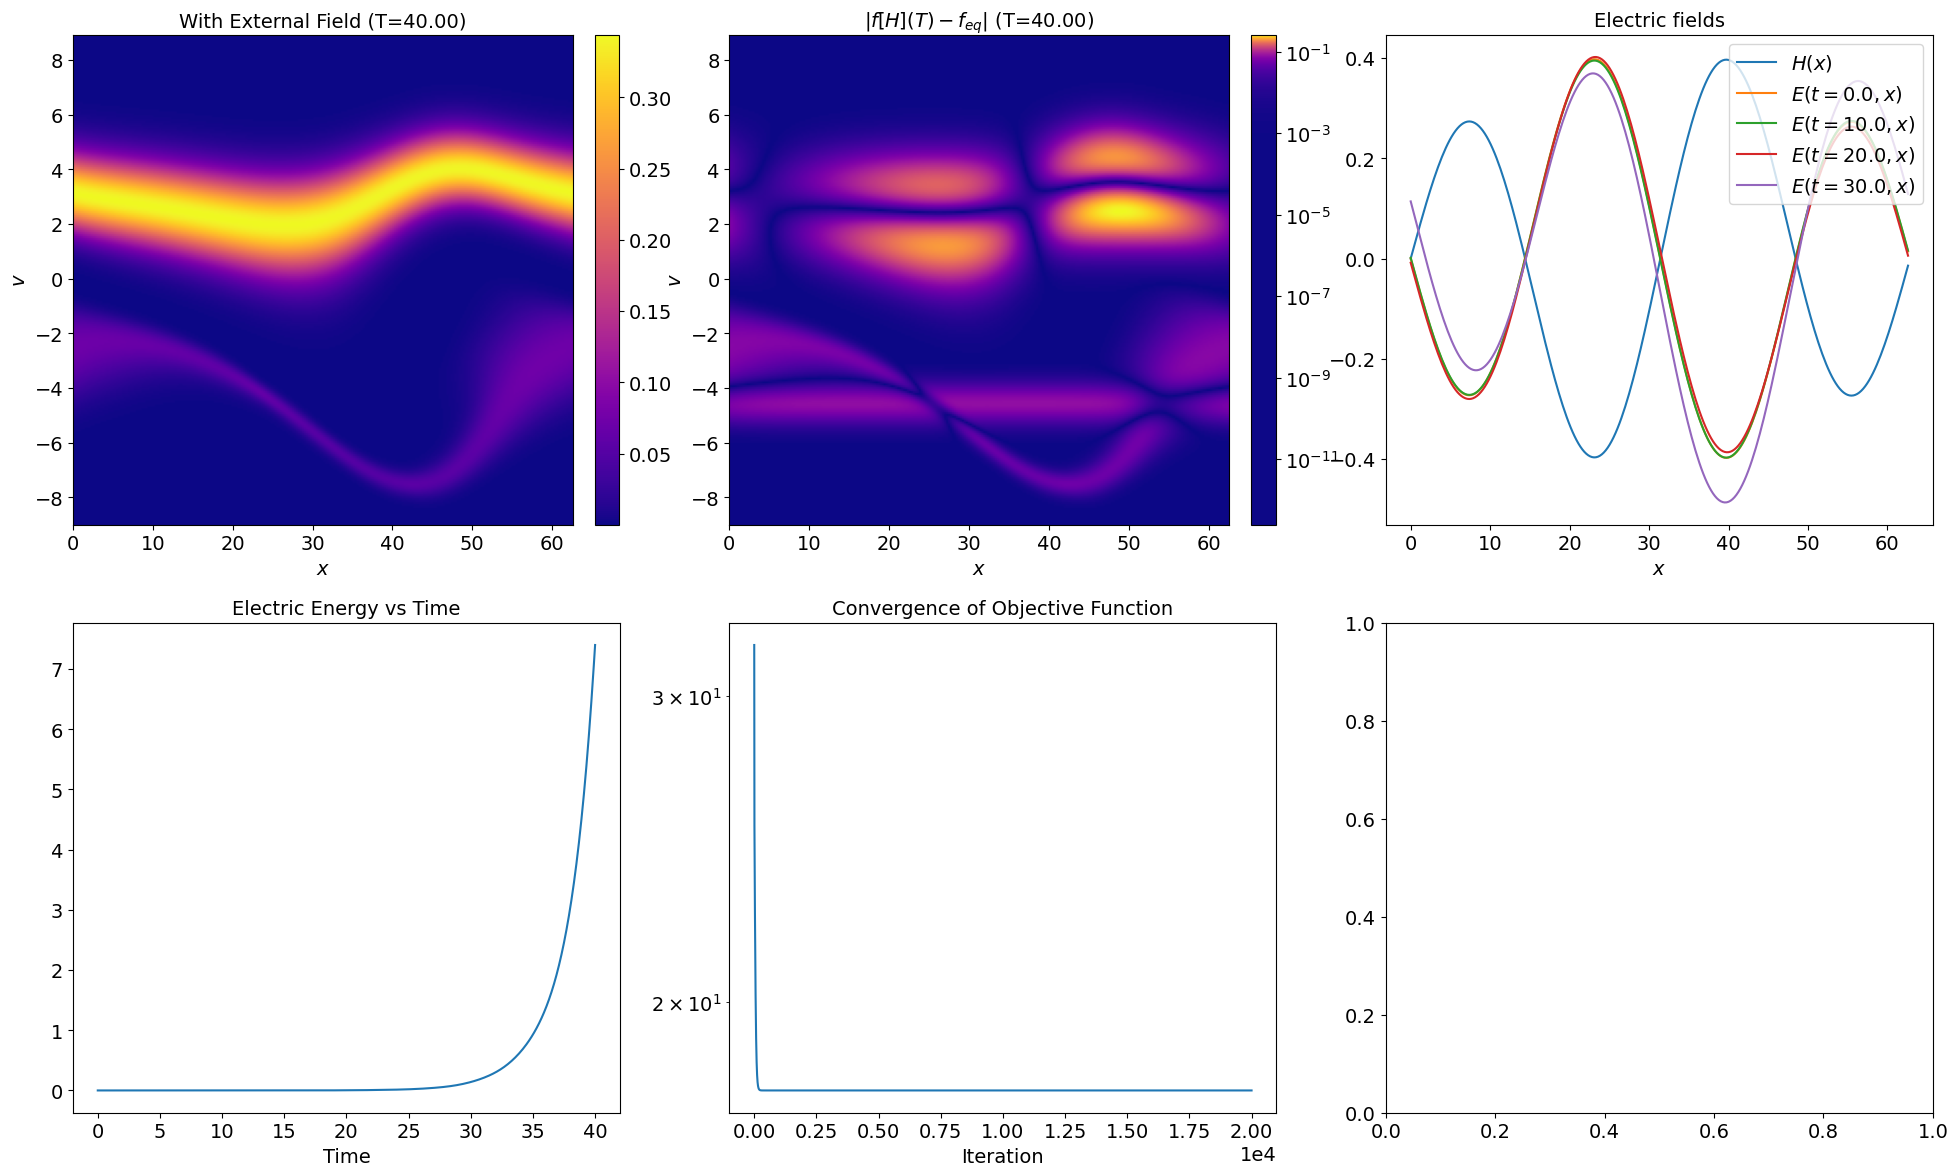

In [45]:
fig, axs = plt.subplots(2,3 ,figsize=(24, 14))


plot_distribution(fig, axs[0,0], f_array3, 'With External Field', t_final, mesh)

plot_distribution(fig, axs[0,1], jnp.abs(f_array3 - f_eq), '$|f[H](T) - f_{eq}|$', t_final, mesh, sci=True)


axs[0,2].plot(mesh.xs, H_far, label='$H(x)$')
#axs[0,2].plot(mesh.xs, E_array3[-1] - H_local, label='$E(T,x)$')
axs[0,2].plot(mesh.xs, E_array3[0] - H_far, label=f'$E(t={0*dt:.1f},x)$')
axs[0,2].plot(mesh.xs, E_array3[99] - H_far, label=f'$E(t={100*dt:.1f},x)$')
axs[0,2].plot(mesh.xs, E_array3[199] - H_far, label=f'$E(t={200*dt:.1f},x)$')
axs[0,2].plot(mesh.xs, E_array3[299] - H_far, label=f'$E(t={300*dt:.1f},x)$')
axs[0,2].set_xlabel('$x$')
#axs[0,2].set_ylabel('Electric field')
axs[0,2].set_title('Electric fields')
axs[0,2].legend(loc='upper right')



#axs[1,0].plot(mesh.xs, E_array3[0] - H_local, label=f't={0*dt:.1f}')
#axs[1,0].plot(mesh.xs, E_array3[99] - H_local, label=f't={100*dt:.1f}')
#axs[1,0].plot(mesh.xs, E_array3[199] - H_local, label=f't={200*dt:.1f}')
#axs[1,0].plot(mesh.xs, E_array3[299] - H_local, label=f't={300*dt:.1f}')
#axs[1,0].set_xlabel('$x$')
#axs[1,0].set_ylabel('$E(t,x)$')
#axs[1,0].set_title('$E(t,x)$ at different times')
#axs[1,0].legend()


axs[1,0].ticklabel_format(axis='y', style='sci', scilimits=(-2,2))
axs[1,0].plot(t_values, ee_array3)
axs[1,0].set_xlabel('Time')
#axs[1,0].set_ylabel('Electric Energy')
axs[1,0].set_title('Electric Energy vs Time')


axs[1,1].ticklabel_format(axis='both', style='sci', scilimits=(0,0))
axs[1,1].plot(objectives_local)
axs[1,1].set_yscale('log')
axs[1,1].set_xlabel("Iteration")
#axs[1,1].set_ylabel("Objective value")
axs[1,1].set_title("Convergence of Objective Function")


## Add subplot here


#plt.savefig('Plots/Two_Stream/GD_ee_eps1={}_eps2={}_k={}_coeffs_local.png'.format(epsilon1,epsilon2, k_total_1),
#            dpi=300, transparent=True, bbox_inches="tight")
plt.show()

### Bump-on-Tail

In [31]:
# Setup
nx = 256
nv = 256
dt = 0.1
t_final = 40  # Adjusted for demonstration purposes
t_values = jnp.linspace(0, t_final, int(t_final / dt))
L = 20 * jnp.pi
LV = 9.0

In [32]:
mesh = make_mesh(L, LV, nx, nv)

mu1 = -3
mu2 = 4.5
f_eq = (9 * jnp.exp(-0.5 * (mesh.V - mu1)**2))/(10*jnp.sqrt(2*jnp.pi))\
        + (jnp.sqrt(2) * jnp.exp(-2 * (mesh.V - mu2)**2))/(10*jnp.sqrt(jnp.pi))
epsilon1 = 0.001
epsilon2 = 0.0
k_0 = 0.1
f_iv = (epsilon1 * jnp.cos(k_0 * mesh.X) + epsilon2 * jnp.sin(k_0 * mesh.X)) \
        * (jnp.sqrt(2) * jnp.exp(-2 * (mesh.V - mu2)**2)) / (10*jnp.sqrt(jnp.pi)) + f_eq

In [33]:
solver = VlasovPoissonSolver(mesh=mesh, dt=dt, f_eq=f_eq)

# JIT-compiled forward solver
solver_jit = jax.jit(solver.run_forward_jax_scan, static_argnames=('t_final',))

In [34]:
#f_array1, E_array1, ee_array1 = solver_jit(f_iv, jnp.zeros_like(f_eq[0,:]), t_final=t_final)

In [ ]:
#fig, axs = plt.subplots(1,4 ,figsize=(40, 7))


#plot_feq_distribution(fig, axs[0], f_eq, 'Distribution of $f_{eq}$', mesh)

#plot_distribution(fig, axs[1], f_array1, 'Distribution of $f$', t_final, mesh)

#axs[2].plot(mesh.xs, E_array1[0], label=f't={0*dt:.1f}')
#axs[2].plot(mesh.xs, E_array1[99], label=f't={100*dt:.1f}')
#axs[2].plot(mesh.xs, E_array1[199], label=f't={200*dt:.1f}')
#axs[2].plot(mesh.xs, E_array1[299], label=f't={300*dt:.1f}')
#axs[2].set_xlabel('$x$')
#axs[2].set_ylabel('$E(t,x)$')
#axs[2].set_title('$E(t,x)$ at different times')
#axs[2].legend()

#axs[3].ticklabel_format(axis='y', style='sci', scilimits=(-2,2))
#axs[3].plot(t_values, ee_array1)
#axs[3].set_xlabel('Time')
#axs[3].set_title('Electric Energy vs Time')


#plt.savefig('Plots/BoT_noH.png', dpi=300, transparent=True, bbox_inches="tight")
#plt.show()


Below change between
- `k_total_1` (under) and `k_total_2` (over) for results with different parametrizations of $H$,
- `ee` (electric energy) and `KL`,
- `GD` (constant step) and `GDL` (linesearch).

Try all combinations (total should be $24$).

In [35]:
aks_far = jnp.load('Results_coeff/Bump-on-Tail/GD/GD_ee_eps1={}_eps2={}_k={}_coeffs_far.npy'.format(epsilon1,epsilon2, k_total_1))
objectives_far = jnp.load('Results_coeff/Bump-on-Tail/GD/GD_ee_eps1={}_eps2={}_k={}_objective_far.npy'.format(epsilon1,epsilon2, k_total_1))

In [36]:
aks_near = jnp.load('Results_coeff/Bump-on-Tail/GD/GD_ee_eps1={}_eps2={}_k={}_coeffs_near.npy'.format(epsilon1,epsilon2, k_total_1))
objectives_near = jnp.load('Results_coeff/Bump-on-Tail/GD/GD_ee_eps1={}_eps2={}_k={}_objective_near.npy'.format(epsilon1,epsilon2, k_total_1))

In [37]:
aks_local = jnp.load('Results_coeff/Bump-on-Tail/GD/GD_ee_eps1={}_eps2={}_k={}_coeffs_local.npy'.format(epsilon1,epsilon2, k_total_1))
objectives_local = jnp.load('Results_coeff/Bump-on-Tail/GD/GD_ee_eps1={}_eps2={}_k={}_objective_local.npy'.format(epsilon1,epsilon2, k_total_1))

In [38]:
H_far = compute_external_field_sin(aks_far[-1], mesh)
H_near = compute_external_field_sin(aks_near[-1], mesh)
H_local = compute_external_field_sin(aks_local[-1], mesh)

f_array1, E_array1, ee_array1 = solver_jit(f_iv, H_far, t_final=t_final)
f_array2, E_array2, ee_array2 = solver_jit(f_iv, H_near, t_final=t_final)
f_array3, E_array3, ee_array3 = solver_jit(f_iv, H_local, t_final=t_final)

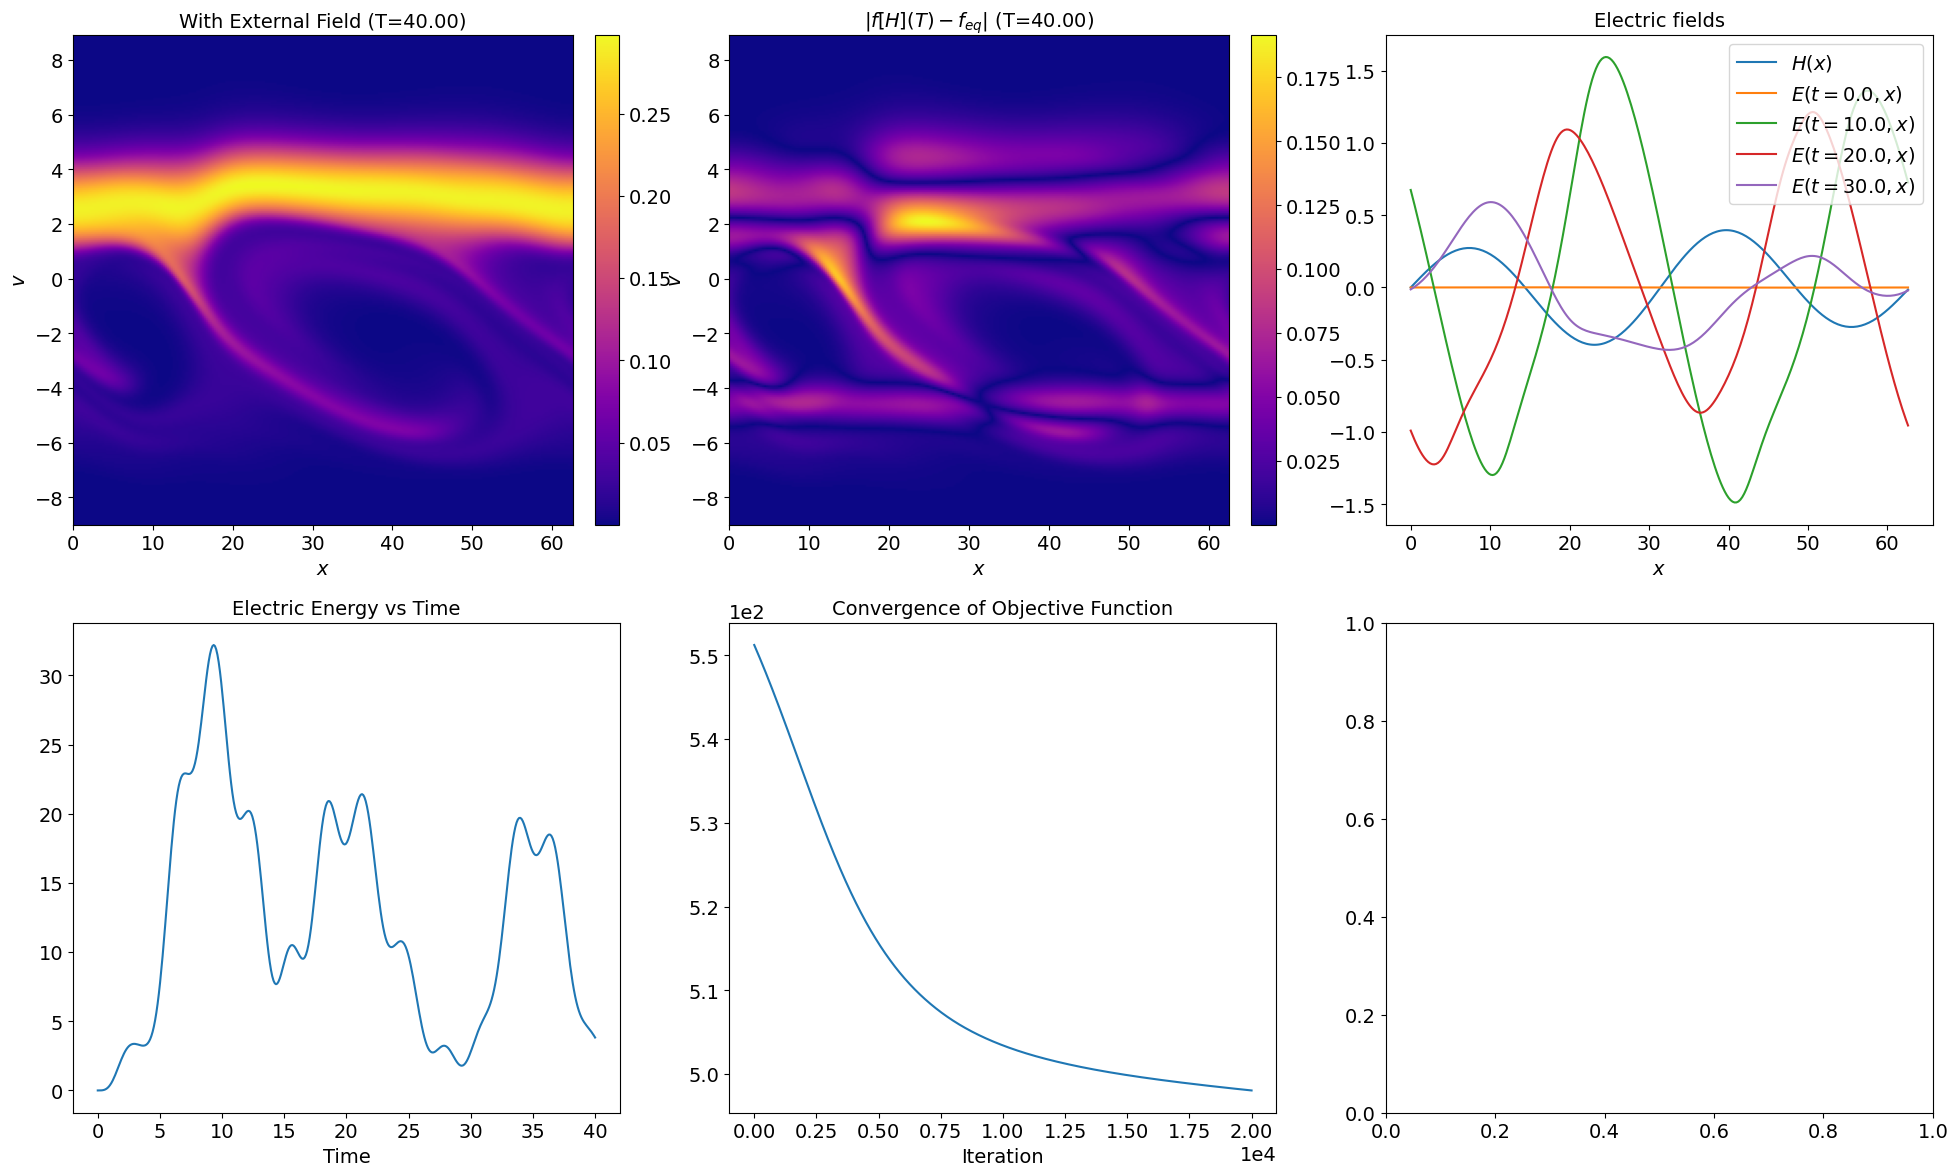

In [39]:
fig, axs = plt.subplots(2,3 ,figsize=(24, 14))


plot_distribution(fig, axs[0,0], f_array1, 'With External Field', t_final, mesh)

plot_distribution(fig, axs[0,1], jnp.abs(f_array1 - f_eq), '$|f[H](T) - f_{eq}|$', t_final, mesh)


axs[0,2].plot(mesh.xs, H_far, label='$H(x)$')
#axs[0,2].plot(mesh.xs, E_array1[-1] - H_far, label='$E(T,x)$')
axs[0,2].plot(mesh.xs, E_array1[0] - H_far, label=f'$E(t={0*dt:.1f},x)$')
axs[0,2].plot(mesh.xs, E_array1[99] - H_far, label=f'$E(t={100*dt:.1f},x)$')
axs[0,2].plot(mesh.xs, E_array1[199] - H_far, label=f'$E(t={200*dt:.1f},x)$')
axs[0,2].plot(mesh.xs, E_array1[299] - H_far, label=f'$E(t={300*dt:.1f},x)$')
axs[0,2].set_xlabel('$x$')
#axs[0,2].set_ylabel('Electric field')
axs[0,2].set_title('Electric fields')
axs[0,2].legend(loc='upper right')



#axs[1,0].plot(mesh.xs, E_array1[0] - H_far, label=f't={0*dt:.1f}')
#axs[1,0].plot(mesh.xs, E_array1[99] - H_far, label=f't={100*dt:.1f}')
#axs[1,0].plot(mesh.xs, E_array1[199] - H_far, label=f't={200*dt:.1f}')
#axs[1,0].plot(mesh.xs, E_array1[299] - H_far, label=f't={300*dt:.1f}')
#axs[1,0].set_xlabel('$x$')
#axs[1,0].set_ylabel('$E(t,x)$')
#axs[1,0].set_title('$E(t,x)$ at different times')
#axs[1,0].legend()


axs[1,0].ticklabel_format(axis='y', style='sci', scilimits=(-2,2))
axs[1,0].plot(t_values, ee_array1)
axs[1,0].set_xlabel('Time')
#axs[1,0].set_ylabel('Electric Energy')
axs[1,0].set_title('Electric Energy vs Time')


axs[1,1].ticklabel_format(axis='both', style='sci', scilimits=(0,0))#, useMathText=True)
axs[1,1].plot(objectives_far)
#axs[1,1].set_yscale('log')
axs[1,1].set_xlabel("Iteration")
#axs[1,1].set_ylabel("Objective value")
axs[1,1].set_title("Convergence of Objective Function")



# Add last subplot here



#plt.savefig('Plots/Bump-on-Tail/GD_ee_eps1={}_eps2={}_k={}_coeffs_far.png'.format(epsilon1,epsilon2, k_total_1),
#            dpi=300, transparent=True, bbox_inches="tight")
plt.show()

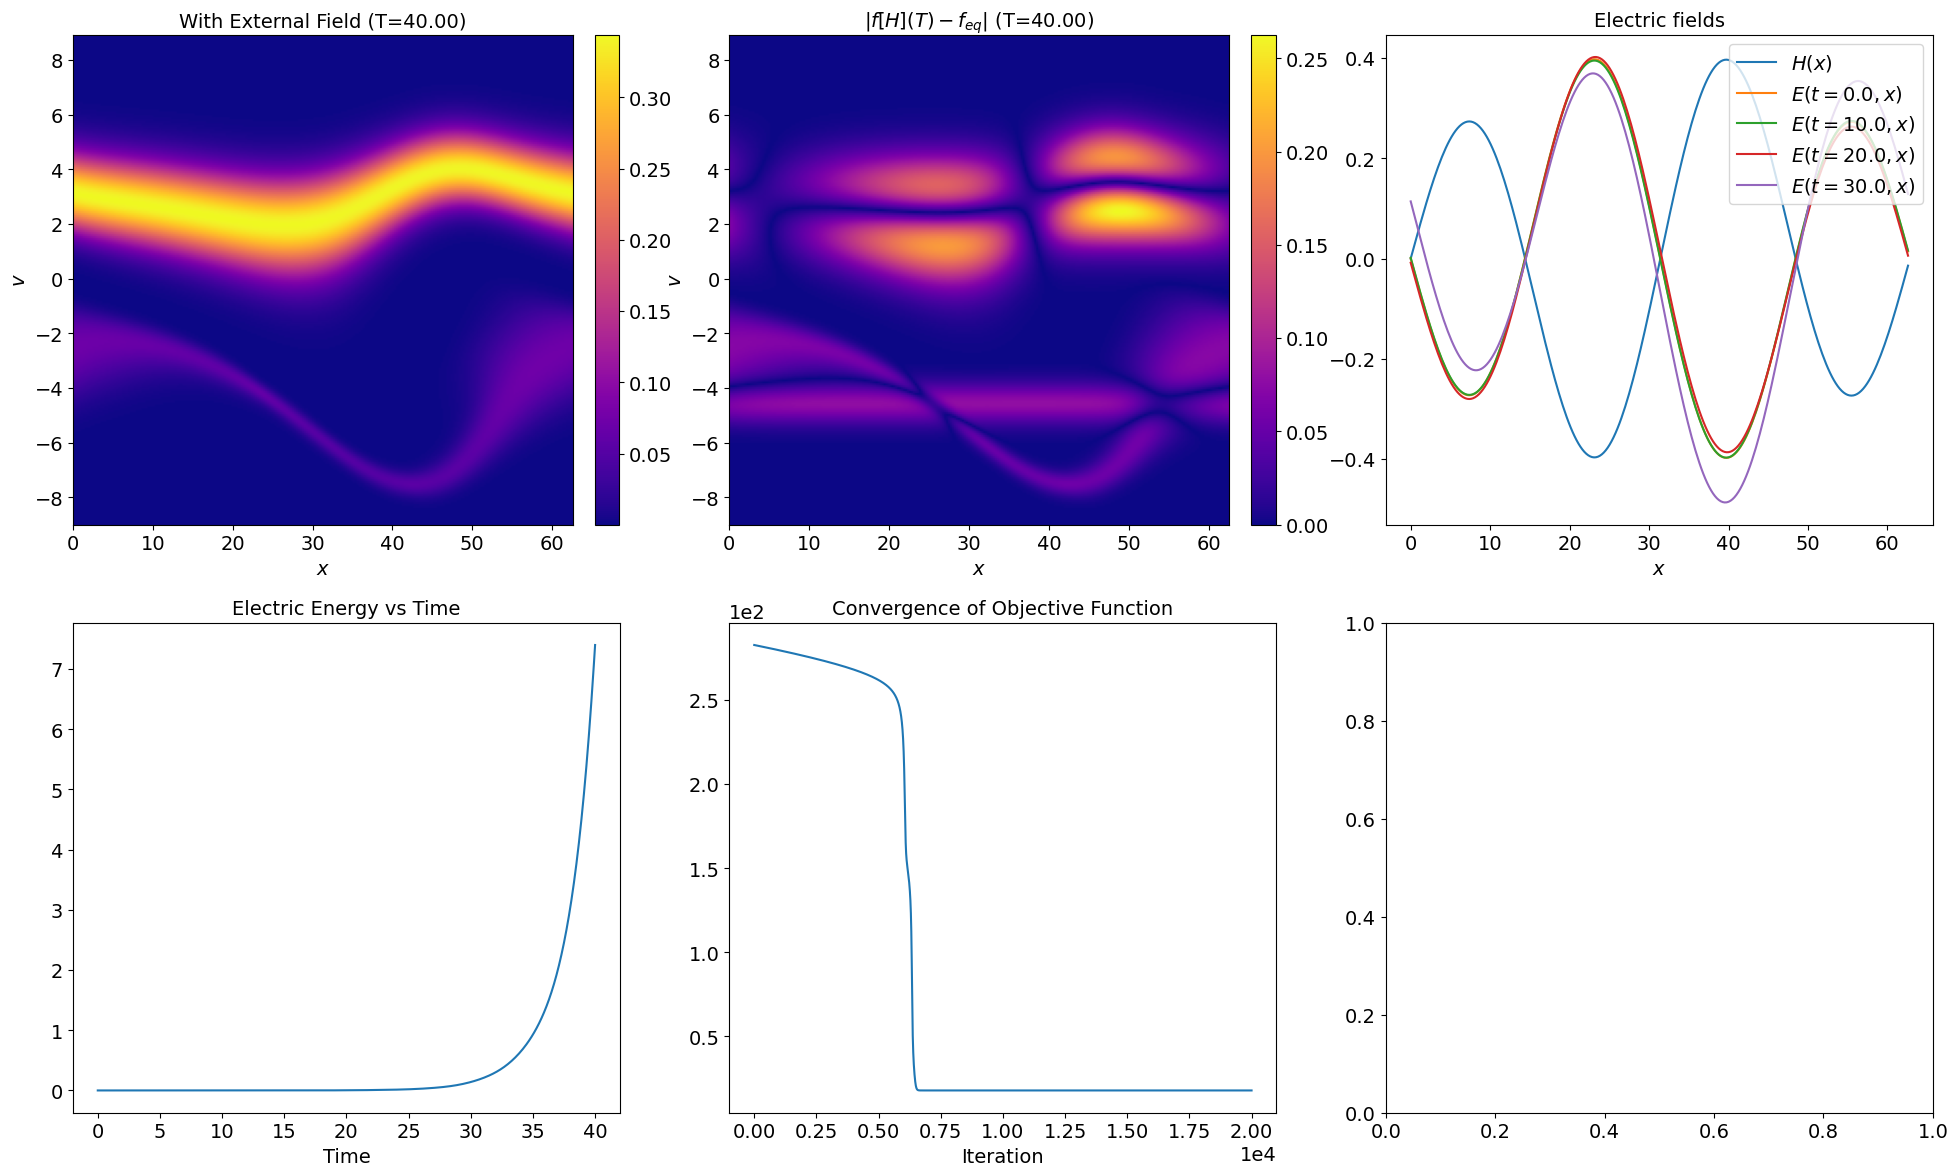

In [42]:
fig, axs = plt.subplots(2,3 ,figsize=(24, 14))



plot_distribution(fig, axs[0,0], f_array2, 'With External Field', t_final, mesh)

plot_distribution(fig, axs[0,1], jnp.abs(f_array2 - f_eq), '$|f[H](T) - f_{eq}|$', t_final, mesh)


axs[0,2].plot(mesh.xs, H_far, label='$H(x)$')
#axs[0,2].plot(mesh.xs, E_array2[-1] - H_near, label='$E(T,x)$')
axs[0,2].plot(mesh.xs, E_array2[0] - H_far, label=f'$E(t={0*dt:.1f},x)$')
axs[0,2].plot(mesh.xs, E_array2[99] - H_far, label=f'$E(t={100*dt:.1f},x)$')
axs[0,2].plot(mesh.xs, E_array2[199] - H_far, label=f'$E(t={200*dt:.1f},x)$')
axs[0,2].plot(mesh.xs, E_array2[299] - H_far, label=f'$E(t={300*dt:.1f},x)$')
axs[0,2].set_xlabel('$x$')
#axs[0,2].set_ylabel('Electric field')
axs[0,2].set_title('Electric fields')
axs[0,2].legend(loc='upper right')



#axs[1,0].plot(mesh.xs, E_array2[0] - H_near, label=f't={0*dt:.1f}')
#axs[1,0].plot(mesh.xs, E_array2[99] - H_near, label=f't={100*dt:.1f}')
#axs[1,0].plot(mesh.xs, E_array2[199] - H_near, label=f't={200*dt:.1f}')
#axs[1,0].plot(mesh.xs, E_array2[299] - H_near, label=f't={300*dt:.1f}')
#axs[1,0].set_xlabel('$x$')
#axs[1,0].set_ylabel('$E(t,x)$')
#axs[1,0].set_title('$E(t,x)$ at different times')
#axs[1,0].legend()


axs[1,0].ticklabel_format(axis='y', style='sci', scilimits=(-2,2))
axs[1,0].plot(t_values, ee_array2)
axs[1,0].set_xlabel('Time')
#axs[1,0].set_ylabel('Electric Energy')
axs[1,0].set_title('Electric Energy vs Time')


axs[1,1].ticklabel_format(axis='both', style='sci', scilimits=(0,0))
axs[1,1].plot(objectives_near)
#axs[1,1].set_yscale('log')
axs[1,1].set_xlabel("Iteration")
#axs[1,1].set_ylabel("Objective value")
axs[1,1].set_title("Convergence of Objective Function")


## Add subplot here


#plt.savefig('Plots/Bump-on-Tail/GD_ee_eps1={}_eps2={}_k={}_coeffs_near.png'.format(epsilon1,epsilon2, k_total_1),
#            dpi=300, transparent=True, bbox_inches="tight")
plt.show()

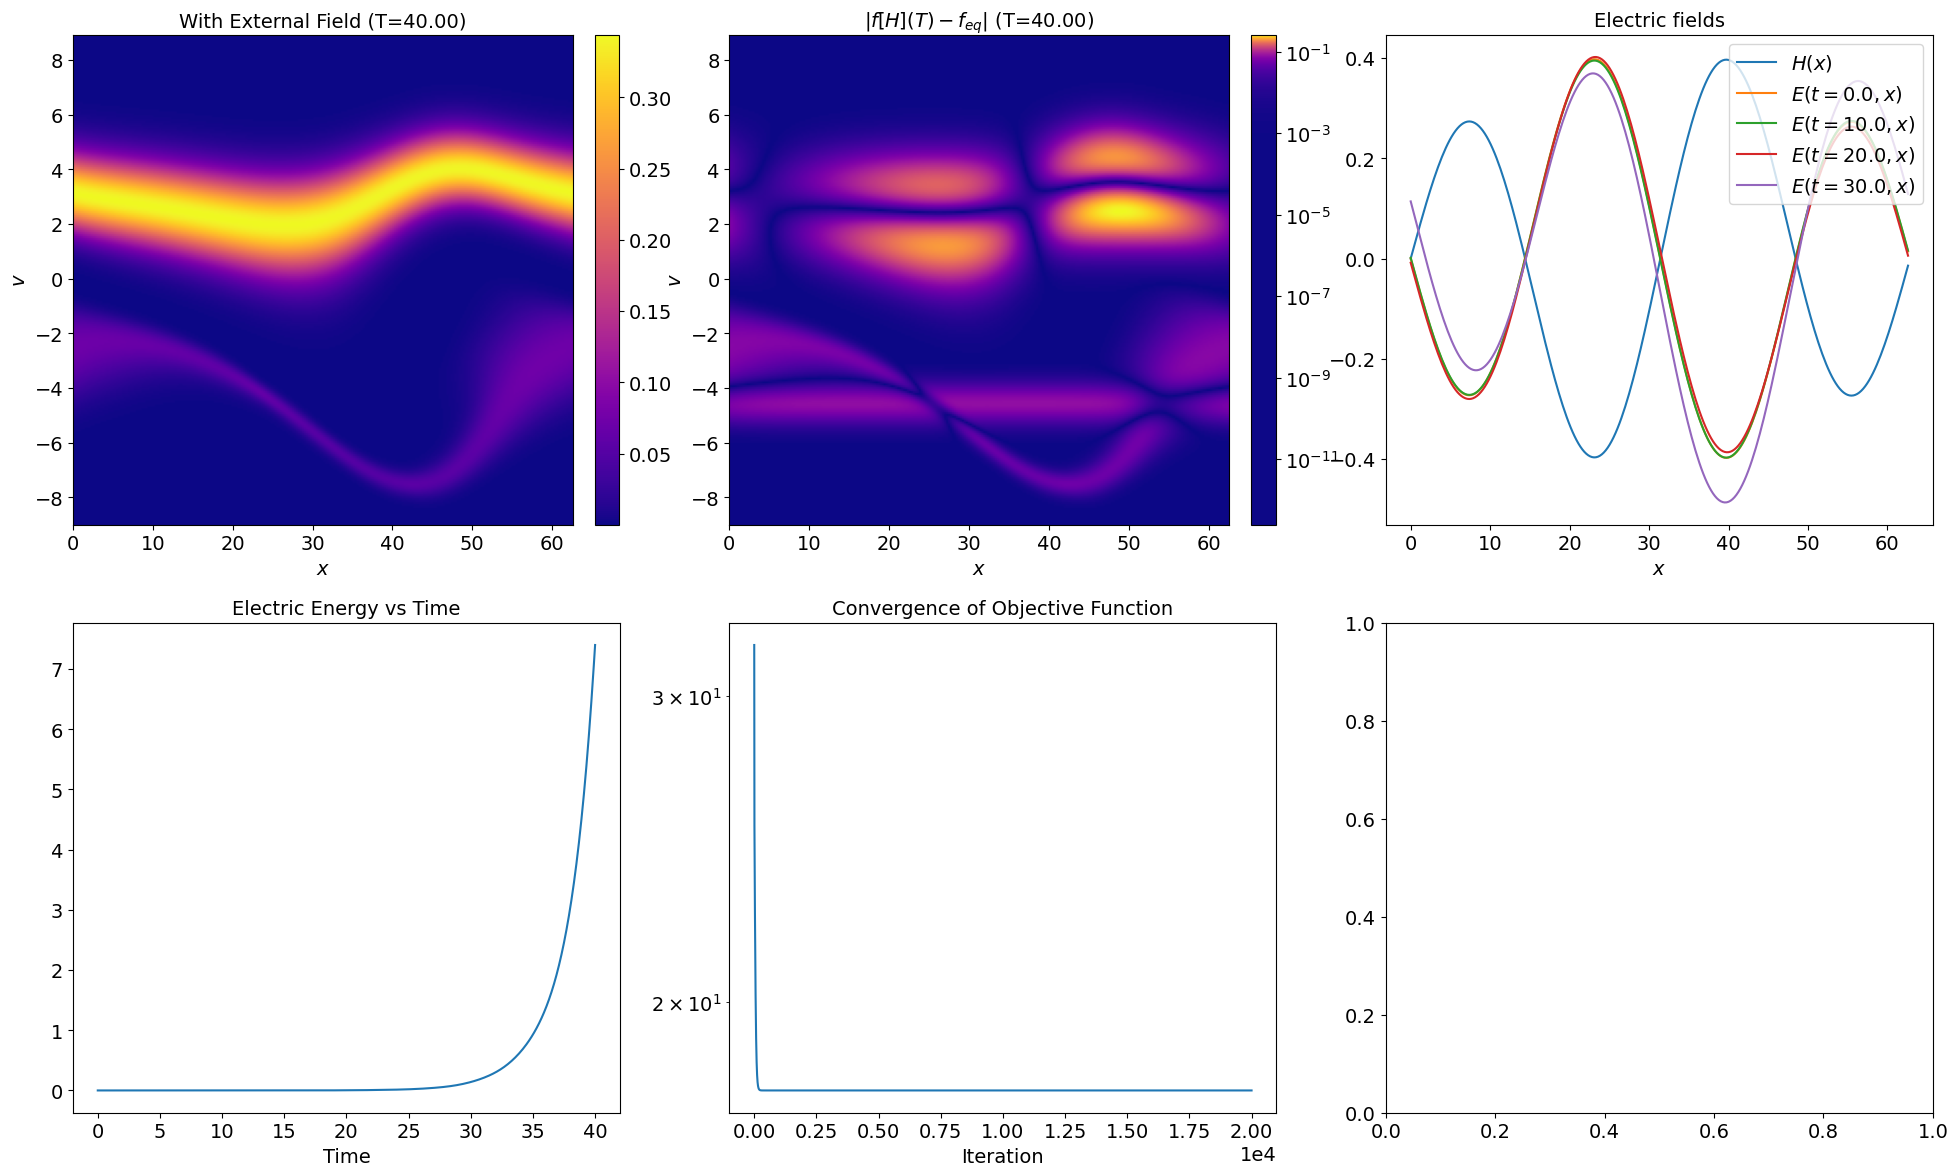

In [43]:
fig, axs = plt.subplots(2,3 ,figsize=(24, 14))


plot_distribution(fig, axs[0,0], f_array3, 'With External Field', t_final, mesh)

plot_distribution(fig, axs[0,1], jnp.abs(f_array3 - f_eq), '$|f[H](T) - f_{eq}|$', t_final, mesh, sci=True)


axs[0,2].plot(mesh.xs, H_far, label='$H(x)$')
#axs[0,2].plot(mesh.xs, E_array3[-1] - H_local, label='$E(T,x)$')
axs[0,2].plot(mesh.xs, E_array3[0] - H_far, label=f'$E(t={0*dt:.1f},x)$')
axs[0,2].plot(mesh.xs, E_array3[99] - H_far, label=f'$E(t={100*dt:.1f},x)$')
axs[0,2].plot(mesh.xs, E_array3[199] - H_far, label=f'$E(t={200*dt:.1f},x)$')
axs[0,2].plot(mesh.xs, E_array3[299] - H_far, label=f'$E(t={300*dt:.1f},x)$')
axs[0,2].set_xlabel('$x$')
#axs[0,2].set_ylabel('Electric field')
axs[0,2].set_title('Electric fields')
axs[0,2].legend(loc='upper right')



#axs[1,0].plot(mesh.xs, E_array3[0] - H_local, label=f't={0*dt:.1f}')
#axs[1,0].plot(mesh.xs, E_array3[99] - H_local, label=f't={100*dt:.1f}')
#axs[1,0].plot(mesh.xs, E_array3[199] - H_local, label=f't={200*dt:.1f}')
#axs[1,0].plot(mesh.xs, E_array3[299] - H_local, label=f't={300*dt:.1f}')
#axs[1,0].set_xlabel('$x$')
#axs[1,0].set_ylabel('$E(t,x)$')
#axs[1,0].set_title('$E(t,x)$ at different times')
#axs[1,0].legend()


axs[1,0].ticklabel_format(axis='y', style='sci', scilimits=(-2,2))
axs[1,0].plot(t_values, ee_array3)
axs[1,0].set_xlabel('Time')
#axs[1,0].set_ylabel('Electric Energy')
axs[1,0].set_title('Electric Energy vs Time')


axs[1,1].ticklabel_format(axis='both', style='sci', scilimits=(0,0))
axs[1,1].plot(objectives_local)
axs[1,1].set_yscale('log')
axs[1,1].set_xlabel("Iteration")
#axs[1,1].set_ylabel("Objective value")
axs[1,1].set_title("Convergence of Objective Function")


## Add subplot here


#plt.savefig('Plots/Bump-on-Tail/GD_ee_eps1={}_eps2={}_k={}_coeffs_local.png'.format(epsilon1,epsilon2, k_total_1),
#            dpi=300, transparent=True, bbox_inches="tight")
plt.show()

## Disregard below

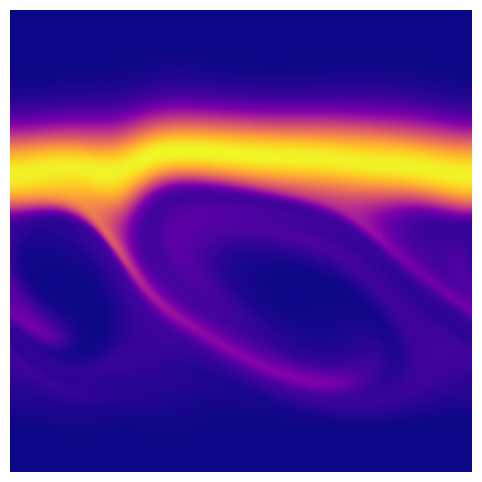

In [53]:
# Create a figure for table in paper (no axis)
fig, ax = plt.subplots(1,1 ,figsize=(8, 6))
ax.imshow(f_array1.transpose(), cmap='plasma')
ax.axis('off')
#plt.savefig('Plots/Bump-on-Tail/Table/GD_ee_eps1={}_eps2={}_k={}_f_table_far.png'.format(epsilon1,epsilon2, k_total_1),
#            dpi=300, transparent=True, bbox_inches="tight")
plt.show()

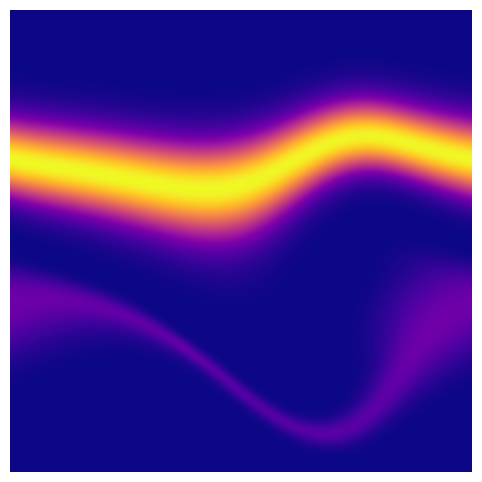

In [54]:
# Create a figure for table in paper (no axis)
fig, ax = plt.subplots(1,1 ,figsize=(8, 6))
ax.imshow(f_array2.transpose(), cmap='plasma')
ax.axis('off')
#plt.savefig('Plots/Bump-on-Tail/Table/GD_ee_eps1={}_eps2={}_k={}_f_table_near.png'.format(epsilon1,epsilon2, k_total_1),
#            dpi=300, transparent=True, bbox_inches="tight")
plt.show()

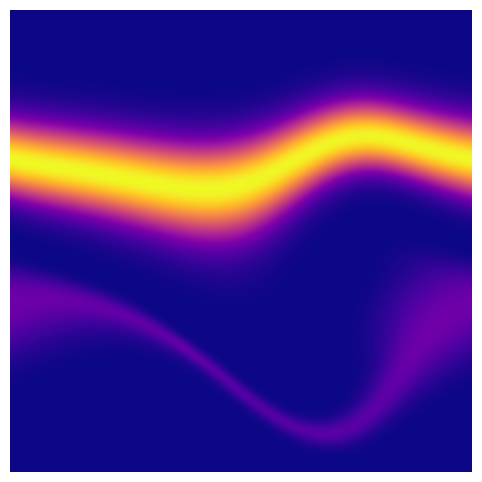

In [55]:
# Create a figure for table in paper (no axis)
fig, ax = plt.subplots(1,1 ,figsize=(8, 6))
ax.imshow(f_array3.transpose(), cmap='plasma')
ax.axis('off')
#plt.savefig('Plots/Bump-on-Tail/Table/GD_ee_eps1={}_eps2={}_k={}_f_table_local.png'.format(epsilon1,epsilon2, k_total_1),
#            dpi=300, transparent=True, bbox_inches="tight")
plt.show()